## **2장 전처리**

### **2-1. 결측치 처리**

#### 결측치 확인

In [52]:
# [데이터 출처] https://archive-beta.ics.uci.edu/dataset/109/wine
from pandas import read_csv
import numpy as np
wine = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv', index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue']) #일부 특징만 사용
print("**원본 데이터:\n", wine.isna().sum())

# 결측치가 없으므로 두 개의 컬럼 Alcohol과 Ash에 임의로 결측치를 입력
from numpy.random import randint
wine_m = wine.copy()
for col in ['Alcohol', 'Ash']:
    random_idx = randint(0, len(wine), 25)
    wine_m.loc[random_idx, col] = np.nan
print("\n**결측치 생성 데이터:\n", wine_m.isna().sum())

**원본 데이터:
 Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

**결측치 생성 데이터:
 Alcohol      25
Malicacid     0
Ash          24
Magnesium     0
Hue           0
dtype: int64


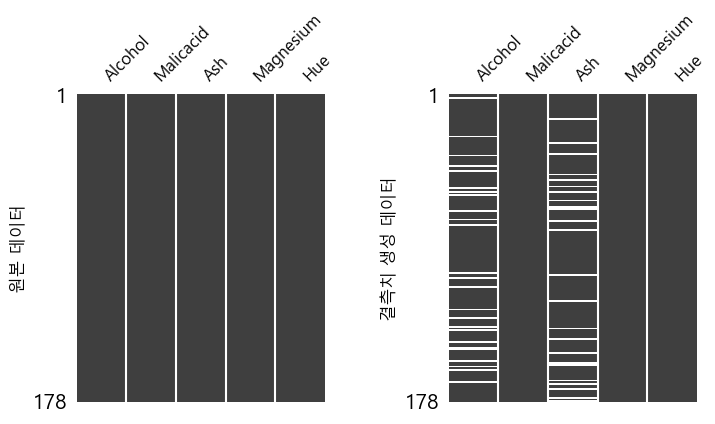

In [53]:
# plotting 환경 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 실제 경로로 대체
font_name = fm.FontProperties(fname=font_path).get_name()

plt.rcParams["font.family"] = font_name # 글꼴
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.size"] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)

import missingno as msno
msno.matrix (df= wine, figsize=(5,5), fontsize = 12, ax=ax[0], sparkline=False)
ax[0].set_ylabel('원본 데이터')

msno.matrix (df= wine_m, figsize=(5,5), fontsize = 12, ax=ax[1], sparkline=False)
ax[1].set_ylabel('결측치 생성 데이터')
plt.show()

#### Zero & Constant Imputation

In [54]:
# 대치 전: wine_m
print(wine_m[['Alcohol', 'Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2      NaN  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6    14.39  2.45
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [55]:
# 0으로 대치 후: wine_imp
wine_imp = wine_m.fillna(0)
print(wine_imp[['Alcohol', 'Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2     0.00  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6    14.39  2.45
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


#### 대푯값으로 채우는 방법

In [56]:
# 결측치를 대푯값 'mean'으로 대치한 데이터셋: wine_imp1
from sklearn.impute import SimpleImputer
from pandas import DataFrame
# strategy = 'mean', 'median' or 'most_frequent'
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
wine_imp1 = imputer.fit_transform(wine_m)
wine_imp1 = DataFrame(wine_imp1, columns = wine_m.columns)

Al_mean = wine_m['Alcohol'].mean()
As_mean = wine_m['Ash'].mean()

print("Alcohol mean: {:.2f}, Ash mean: {:.2f}".format(Al_mean, As_mean))
print(wine_imp1[['Alcohol', 'Ash']].head(10).round(2))

Alcohol mean: 13.01, Ash mean: 2.37
   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.01  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6    14.39  2.45
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [36]:
#조금 더 쉽게...
wine_tmp = wine_m
print(wine_m[['Alcohol', 'Ash']].head(10).round(2))

wine_tmp['Alcohol'] = wine_tmp['Alcohol'].fillna(wine_tmp['Alcohol'].mean())
wine_tmp['Ash'] = wine_tmp['Ash'].fillna(wine_tmp['Ash'].median())

print(wine_tmp[['Alcohol', 'Ash']].head(10).round(2))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6    14.39  2.45
7      NaN  2.61
8    14.83  2.17
9    13.86  2.27
   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6    14.39  2.45
7    13.02  2.61
8    14.83  2.17
9    13.86  2.27


#### 단순확률대치법

In [57]:
# 결측치를 HotDeck 방법으로 대치한 데이터셋: wine_imp2
# wine 데이터가 wine_m 데이터와 비슷한 성향을 가졌다고 가정하고 wine 데이터에서 랜덤하게 데이터를 선택하여 wine_m의 결측치를 대치함
wine_imp2 = wine_m.copy()
for feat in ['Alcohol', 'Ash']:
    missing_idx = wine_imp2[wine_imp2[feat].isna()==True].index
    wine_imp2.loc[missing_idx, feat] = wine[feat].sample(len(missing_idx)).values
    
wine_imp2.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

#### 다른 변수들로부터 모델링을 하여 결측값을 예측하는 방법

In [58]:
# KNNImputer로 결측치를 대치한 데이터셋: wine_imp3
from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=3)
wine_imp3 = imputer.fit_transform(wine_m)
wine_imp3 = DataFrame(wine_imp3, columns=wine_m.columns)
wine_imp3.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

#### 보간법 (주로 시계열 자료에서 활용)

In [59]:
# 선형보간법으로 결측치를 대치한 데이터셋: wine_imp4
wine_imp4 = wine_m.interpolate(method='linear')
wine_imp4.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

#### 실제값과 대치값의 비교

In [60]:
# Alcohol feature 기준으로 결측치를 전처리한 결과를 비교
feature = 'Alcohol'
report = DataFrame({'실제값': wine[feature], "mean대치": wine_imp1[feature], 'Hotdeck': wine_imp2[feature], 'KNN대치': wine_imp3[feature], '선형보간': wine_imp4[feature]})

# 실제값과 대치한 값 사이의 차이를 비교
score_report = DataFrame(index = ['MAE', 'MSE'])
from sklearn.metrics import mean_absolute_error, mean_squared_error
for col in report.columns:
    mae = mean_absolute_error(report['실제값'], report[col])
    mse = mean_squared_error(report['실제값'], report[col])
    score_report.loc['MAE', col] = mae 
    score_report.loc['MSE', col] = mse
print(score_report.round(3))
# 실제값-선형보간대치값의 차이가 가장 작게 나타남

     실제값  mean대치  Hotdeck  KNN대치   선형보간
MAE  0.0   0.090    0.095  0.075  0.077
MSE  0.0   0.073    0.108  0.063  0.060


In [62]:
# Ash feature 기준으로 결측치를 전처리한 결과를 비교
feature = 'Ash'
report = DataFrame({'실제값': wine[feature], "mean대치": wine_imp1[feature], 'Hotdeck': wine_imp2[feature], 'KNN대치': wine_imp3[feature], '선형보간': wine_imp4[feature]})

# 실제값과 대치한 값 사이의 차이를 비교
score_report = DataFrame(index = ['MAE', 'MSE'])
from sklearn.metrics import mean_absolute_error, mean_squared_error
for col in report.columns:
    mae = mean_absolute_error(report['실제값'], report[col])
    mse = mean_squared_error(report['실제값'], report[col])
    score_report.loc['MAE', col] = mae 
    score_report.loc['MSE', col] = mse
print(score_report.round(3))
# 실제값-mean대치값의 차이가 가장 작게 나타남

     실제값  mean대치  Hotdeck  KNN대치  선형보간
MAE  0.0   0.028    0.032  0.027  0.03
MSE  0.0   0.010    0.011  0.009  0.01


### **2-2. 이상치 처리**

In [65]:
from pandas import read_csv
wine = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv', index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue']) #일부 특징만 사용

In [64]:
# 이상치 찾기
IQR = wine['Malicacid'].quantile(0.75) - wine['Malicacid'].quantile(0.25)
top = wine['Malicacid'].quantile(0.75) + IQR * 1.5
down = wine['Malicacid'].quantile(0.25) - IQR * 1.5

#상한선보다 크고, 하한선보다 작은 데이터의 인덱스를 찾음
out_id = wine[(wine['Malicacid']>=top) | (wine['Malicacid']<=down)].index
print("이상치의 index", out_id)

이상치의 index Index([123, 137, 173], dtype='int64')


#### 절단

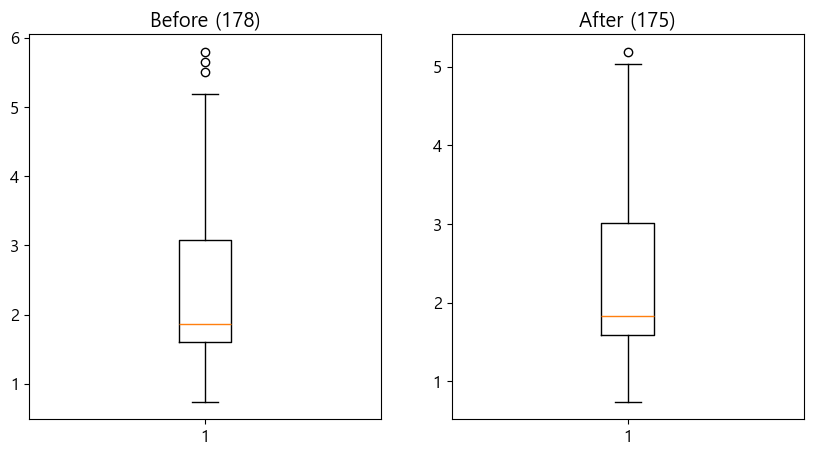

In [101]:
#절단
prep_df = wine['Malicacid'].drop(out_id,axis=0)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].boxplot(wine['Malicacid'])
ax[0].set_title(label='Before ('+str(len(wine['Malicacid']))+')')
ax[1].boxplot(prep_df)
ax[1].set_title(label='After ('+str(len(prep_df))+')')
plt.show()

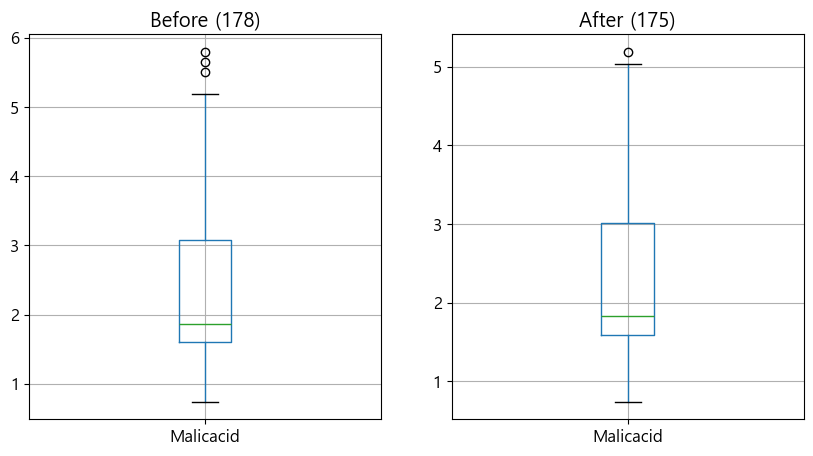

In [99]:
# 절단
prep_df = wine[['Malicacid']].drop(out_id, axis=0)

# 전후 시각화
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

#### 조정

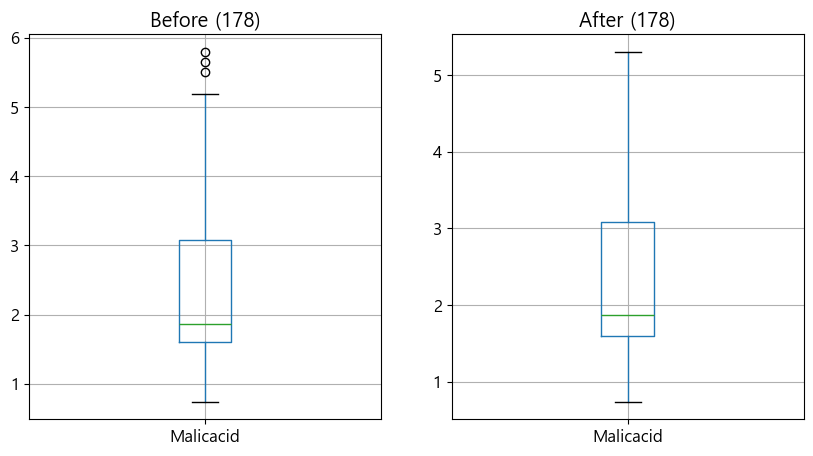

In [103]:
# 조정
prep_df2 = wine[['Malicacid']].clip(down,top)

# 전후 시각화
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df2], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

#### 클리핑

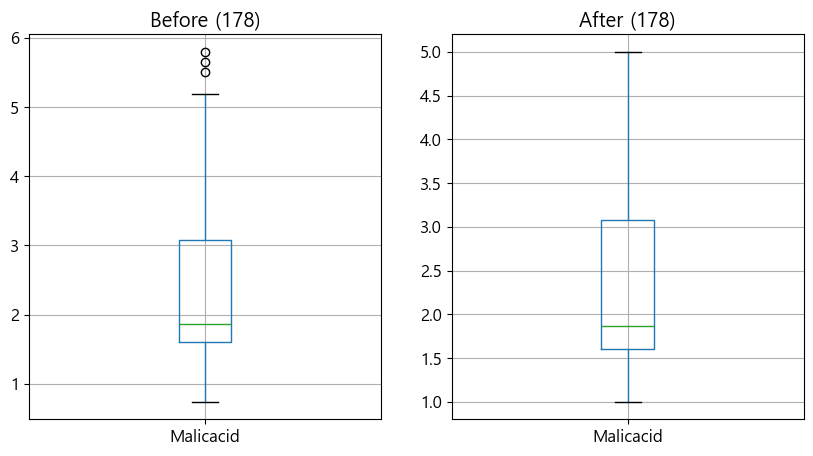

In [104]:
# 클리핑
prep_df3 = wine[['Malicacid']].clip(1, 5)

# 전후 시각화
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df3], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

### **2-3. 클래스 불균형 처리**

In [125]:
from sklearn.datasets import load_breast_cancer
from pandas import DataFrame, concat
import numpy as np
from collections import Counter
# sklearn의 데이터 불러오기
data = load_breast_cancer()
df = DataFrame(np.c_[data['data'], data['target']], 
               columns = list(data.feature_names) + ['target'] )
# 3개의 feature와 target을 추출
df = df.filter(['mean radius', 'mean texture', 'mean area', 'target'])
print("데이터 앞 3개의 행 확인: \n", df.head(3), "\n")
print("original data의 class 분포: ", Counter(df['target']))

# 클래스 불균형한 imb_df 생성
df1 = df[df['target']==0].sample(50)
df2 = df[df['target']==1].sample(250)
imb_df = concat([df1, df2]).reset_index(drop=True)
print("imbalanced data의 class 분포: ", Counter(imb_df['target']))

features = imb_df.drop('target', axis=1)
target = imb_df['target']

데이터 앞 3개의 행 확인: 
    mean radius  mean texture  mean area  target
0        17.99         10.38     1001.0     0.0
1        20.57         17.77     1326.0     0.0
2        19.69         21.25     1203.0     0.0 

original data의 class 분포:  Counter({1.0: 357, 0.0: 212})
imbalanced data의 class 분포:  Counter({1.0: 250, 0.0: 50})


#### 랜덤오버샘플링

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


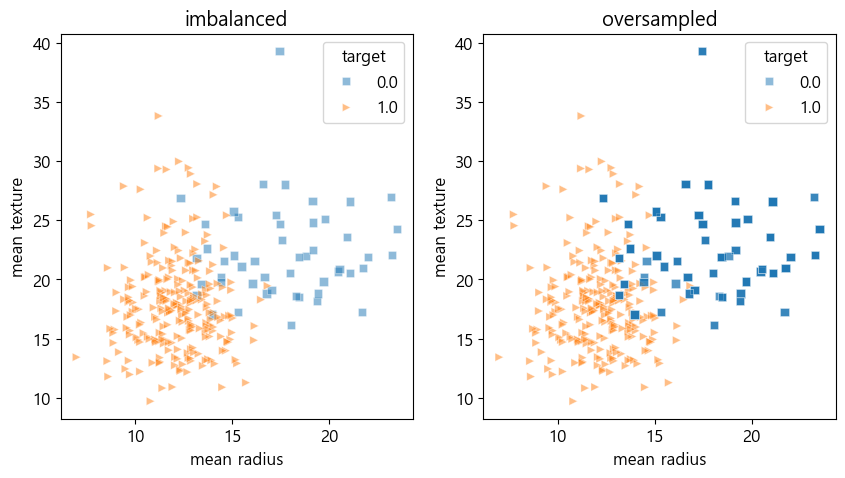

In [129]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(random_state=0)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

import seaborn as sns
over_df1 = DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df, ax=ax[0], alpha=0.5, style='target', markers=['s', '>'])

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df1, ax=ax[1], alpha=0.5, style='target', markers=['s', '>'])
plt.show()

#### SMOTE (Synthetic Minority Oversampling TEchnique)

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


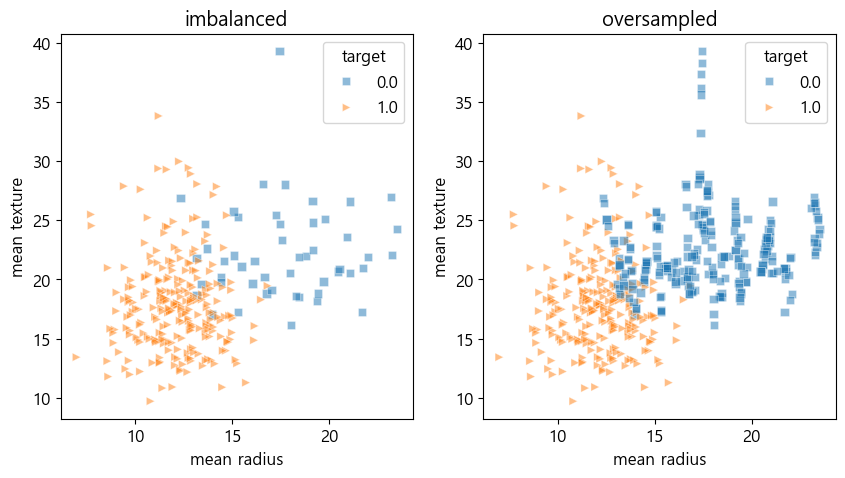

In [130]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

import seaborn as sns
over_df2 = DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df, ax=ax[0], alpha=0.5, style='target', markers=['s', '>'])

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df2, ax=ax[1], alpha=0.5, style='target', markers=['s', '>'])
plt.show()

#### Borderline SMOTE

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


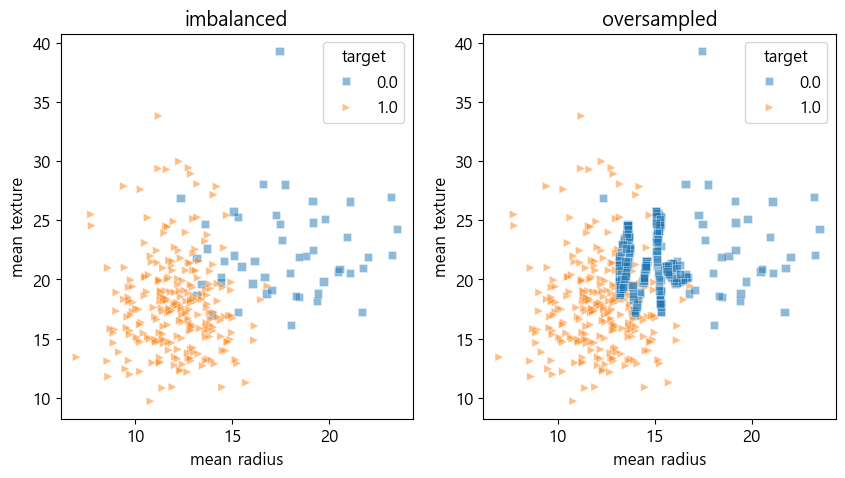

In [131]:
from imblearn.over_sampling import BorderlineSMOTE
os = BorderlineSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

import seaborn as sns
over_df3 = DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df, ax=ax[0], alpha=0.5, style='target', markers=['s', '>'])

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df3, ax=ax[1], alpha=0.5, style='target', markers=['s', '>'])
plt.show()

#### K-means SMOTE

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 252, 1.0: 250})


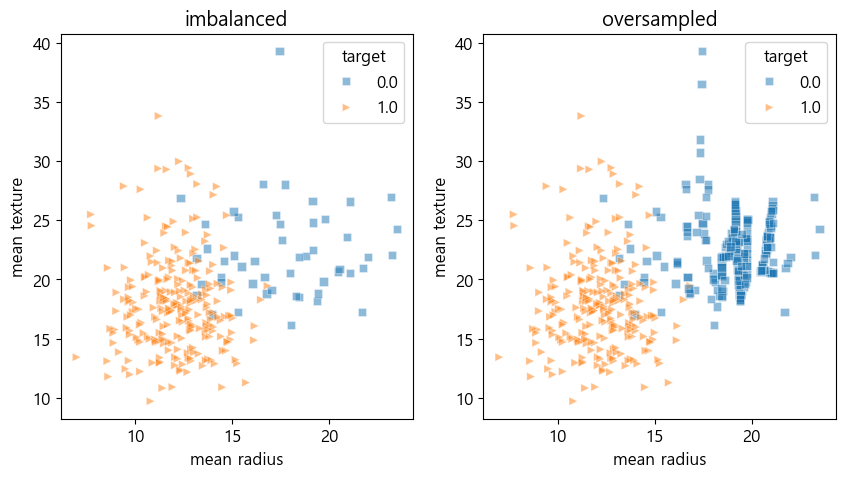

In [133]:
from imblearn.over_sampling import KMeansSMOTE
os = KMeansSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

import seaborn as sns
over_df4 = DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df, ax=ax[0], alpha=0.5, style='target', markers=['s', '>'])

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df4, ax=ax[1], alpha=0.5, style='target', markers=['s', '>'])
plt.show()

#### SVM SMOTE

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


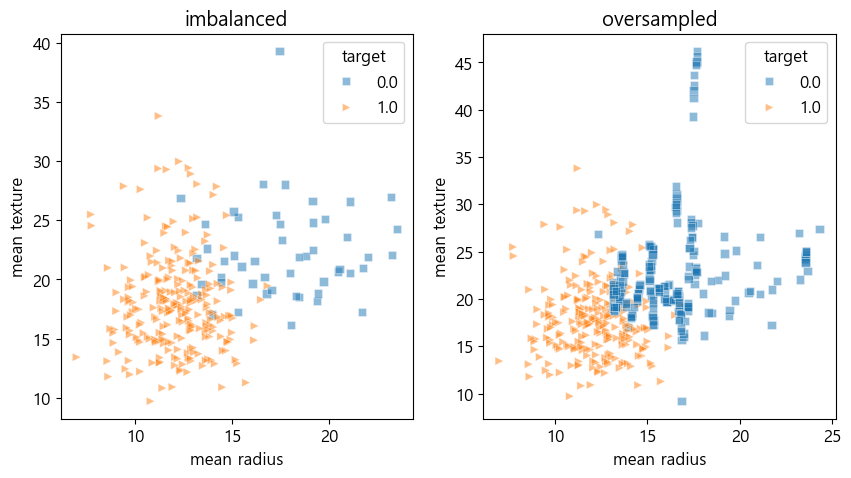

In [137]:
from imblearn.over_sampling import SVMSMOTE 
os = SVMSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

import seaborn as sns
over_df5 = DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df, ax=ax[0], alpha=0.5, style='target', markers=['s', '>'])

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df5, ax=ax[1], alpha=0.5, style='target', markers=['s', '>'])
plt.show()

#### ADASYN (Adaptive Synthetic Sampling)

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({1.0: 250, 0.0: 248})


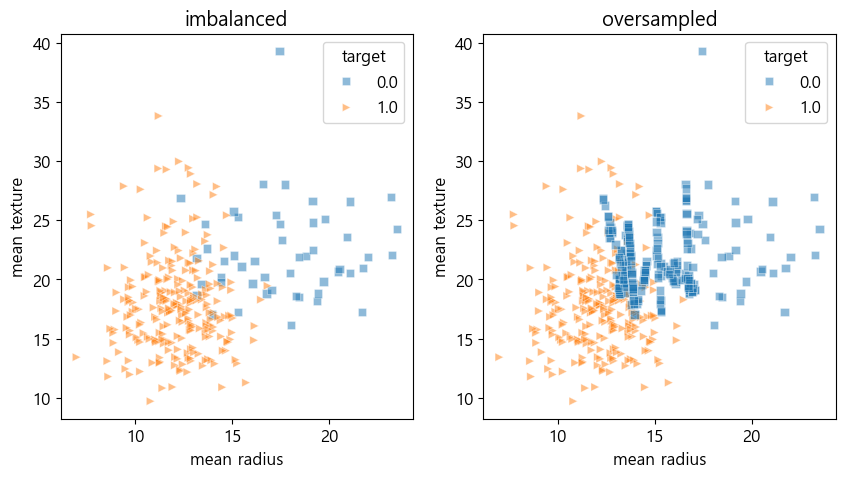

In [144]:
from imblearn.over_sampling import ADASYN
os = ADASYN(random_state=0, n_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

import seaborn as sns
over_df6 = DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df, ax=ax[0], alpha=0.5, style='target', markers=['s', '>'])

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df6, ax=ax[1], alpha=0.5, style='target', markers=['s', '>'])
plt.show()

#### 오버샘플링된 데이터로 분류 학습 및 결과 비교

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
data = [imb_df, over_df1, over_df2, over_df3, over_df4, over_df5, over_df6]
data_title=['no oversampling', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'KMeansSMOTE', 'SVMSMOTE', 'ADASYN']

scores = DataFrame(index=['Train acc', 'Test acc', 'Train F1', 'Test F1'], columns=data_title)

for df, title in zip(data, data_title):
    features = df.drop('target', axis=1) 
    target = df['target']
    X_train, X_test, y_train, y_test = train_test_split(features, target)
    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    scores.loc['Train acc', title]= accuracy_score(y_train, pred_train)
    scores.loc['Test acc', title]= accuracy_score(y_test, pred_test)
    scores.loc['Train F1', title]= f1_score(y_train, pred_train)
    scores.loc['Test F1', title]= f1_score(y_test, pred_test)   
print(scores)

          no oversampling RandomOverSampler     SMOTE BorderlineSMOTE  \
Train acc        0.964444          0.914667  0.898667        0.858667   
Test acc         0.906667             0.888     0.888           0.816   
Train F1         0.978836          0.915344  0.903061        0.850704   
Test F1          0.945736          0.890625  0.892308        0.827068   

          KMeansSMOTE  SVMSMOTE    ADASYN  
Train acc    0.970745     0.856  0.863271  
Test acc     0.968254     0.848     0.824  
Train F1     0.970509     0.865  0.853026  
Test F1      0.970149  0.837607  0.853333  


### **2-4. 변수변환**

#### **2-4-1. 수치형 변수변환**

In [172]:
from pandas import read_csv
diabetes = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_diabetes.csv')
X = diabetes.filter(['Pregnancies', 'BloodPressure', 'BMI', 'Age']) #4개 특성
y = diabetes['Outcome']
print("특성: \n", X.head(1), '\n')
print("타겟: \n", y.head(1))

특성: 
    Pregnancies  BloodPressure   BMI  Age
0            6             72  33.6   50 

타겟: 
 0    1
Name: Outcome, dtype: int64


#### 선형변환: 표준화 (Z-score)

In [162]:
print("[Before] feature 별 데이터 분포 확인:")
print(X.describe().loc[['mean', 'std', 'max', 'min'], :], '\n')

# sklearn의 StandardScaler로 feature scaling
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_X = ss.fit_transform(X)
ss_X = DataFrame(ss_X, columns = X.columns)
print("[After] feature 별 데이터 분포 확인:")
print(ss_X.describe().loc[['mean', 'std', 'max', 'min'], :])

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

[After] feature 별 데이터 분포 확인:
       Pregnancies  BloodPressure           BMI           Age
mean -6.476301e-17   1.503427e-17  2.590520e-16  1.931325e-16
std   1.000652e+00   1.000652e+00  1.000652e+00  1.000652e+00
max   3.906578e+00   2.734528e+00  4.455807e+00  4.063716e+00
min  -1.141852e+00  -3.572597e+00 -4.060474e+00 -1.041549e+00


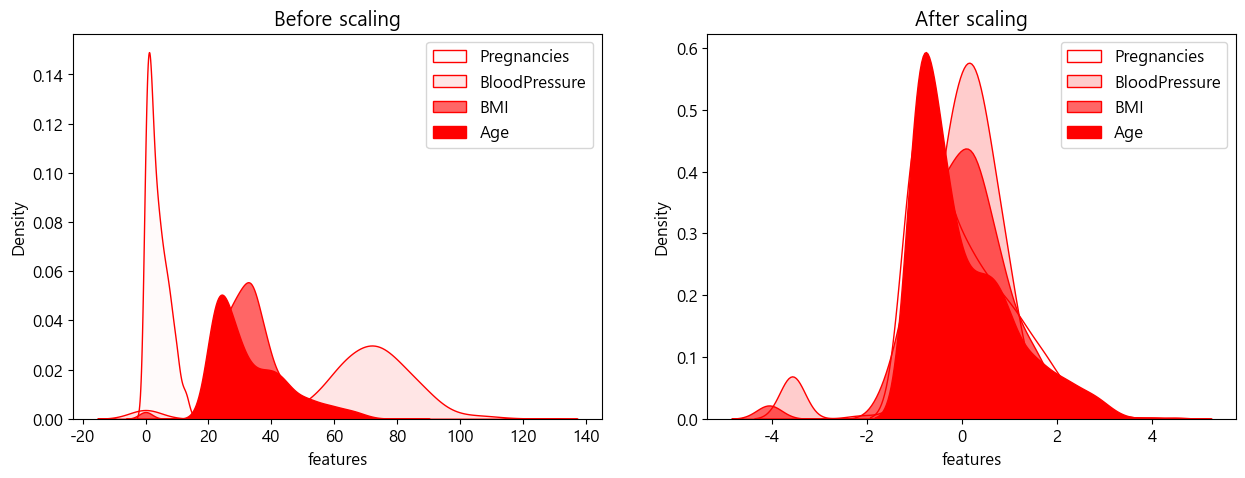

In [158]:
# scaling 전후 데이터 분포 비교 시각화
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], fill=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(ss_X.columns, [0.02, 0.2, 0.6, 1]):
    sns.kdeplot(ss_X[col], alpha=a, legend=True,ax=ax[1], fill=True, color='r')
ax[1].legend(ss_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')
plt.show()

#### 선형변환: 최대최소 스케일링

In [159]:
print("[Before] feature 별 데이터 분포 확인:")
print(X.describe().loc[['mean', 'std', 'max', 'min'], :], '\n')

# sklearn의 MinMaxScaler로 feature scaling
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
mm_X = mm.fit_transform(X)
mm_X = DataFrame(mm_X, columns = X.columns)
print("[After] feature 별 데이터 분포 확인:")
print(mm_X.describe().loc[['mean', 'std', 'max', 'min'], :])

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean      0.22618       0.566438  0.476790  0.204015
std       0.19821       0.158654  0.117499  0.196004
max       1.00000       1.000000  1.000000  1.000000
min       0.00000       0.000000  0.000000  0.000000


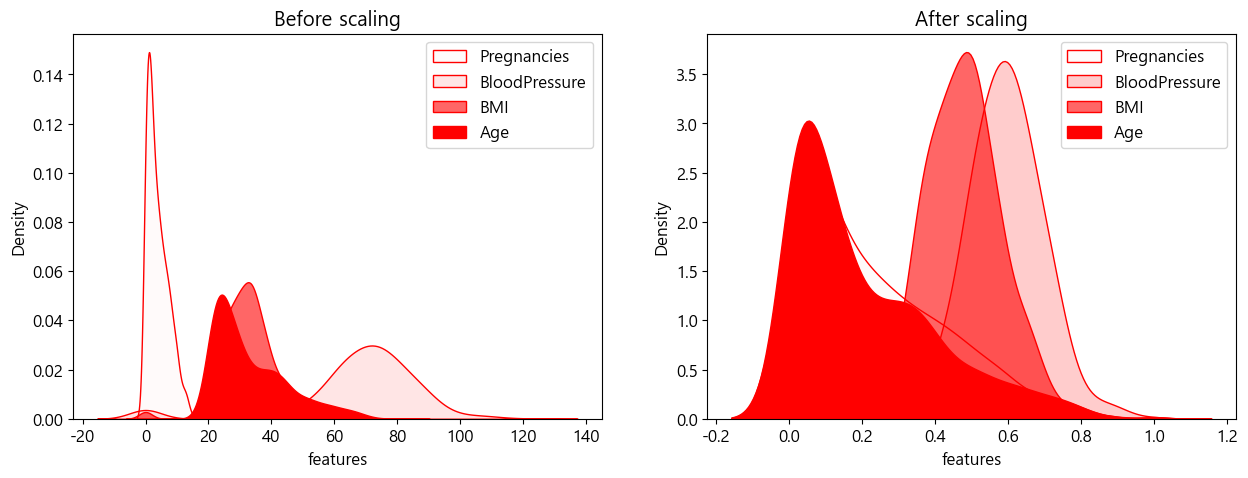

In [164]:
# scaling 전후 데이터 분포 비교 시각화
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col],alpha=a,legend=True,ax=ax[0], fill=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(mm_X.columns, [0.02, 0.2, 0.6, 1]):
    sns.kdeplot(mm_X[col],alpha=a,legend=True,ax=ax[1],fill=True,color='r')
ax[1].legend(mm_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')
plt.show()

#### 선형변환: Robust Scaling

In [165]:
print("[Before] feature 별 데이터 분포 확인:")
print(X.describe().loc[['mean', 'std', 'max', 'min'], :], "\n")

# sklearn의 RobustScaler로 feature scaling
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
rs_X = rs.fit_transform(X)
rs_X = DataFrame(rs_X, columns = X.columns)
print("[After] feature 별 데이터 분포 확인:")
print(rs_X.describe().loc[['mean', 'std', 'max', 'min'], :])

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean     0.169010      -0.160807 -0.000798  0.249464
std      0.673916       1.075323  0.847759  0.691778
max      2.800000       2.777778  3.774194  3.058824
min     -0.600000      -4.000000 -3.440860 -0.470588


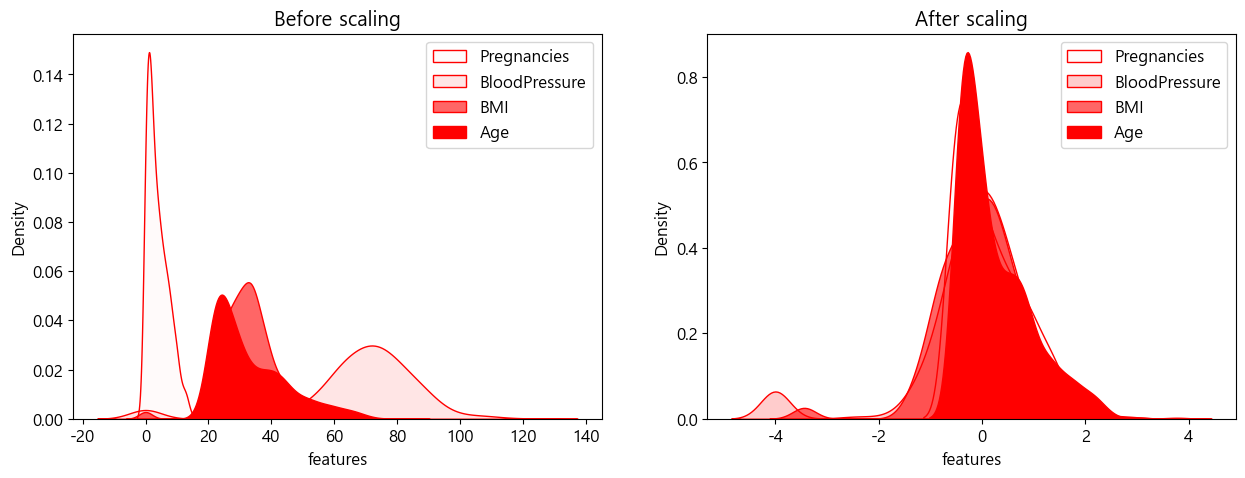

In [167]:
# scaling 전후 데이터 분포 비교 시각화
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col],alpha=a,legend=True,ax=ax[0], fill=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(rs_X.columns, [0.02, 0.2, 0.6, 1]):
    sns.kdeplot(rs_X[col],alpha=a,legend=True,ax=ax[1],fill=True,color='r')
ax[1].legend(rs_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')
plt.show()

#### 선형변환: Quantile Scaling

In [168]:
print("[Before] feature 별 데이터 분포 확인:")
print(X.describe().loc[['mean', 'std', 'max', 'min'], :], "\n")

# sklearn의 QuantileTransformer로 feature scaling
from sklearn.preprocessing import QuantileTransformer
qtu = QuantileTransformer(output_distribution = 'uniform', n_quantiles=len(X))
qtu_X = qtu.fit_transform(X)
qtu_X = DataFrame(qtu_X, columns = X.columns)
print("[After] feature 별 데이터 분포 확인:")
print(qtu_X.describe().loc[['mean', 'std', 'max', 'min'], :])

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean     0.489773       0.499110  0.499972  0.496769
std      0.303331       0.290718  0.289391  0.294365
max      1.000000       1.000000  1.000000  1.000000
min      0.000000       0.000000  0.000000  0.000000


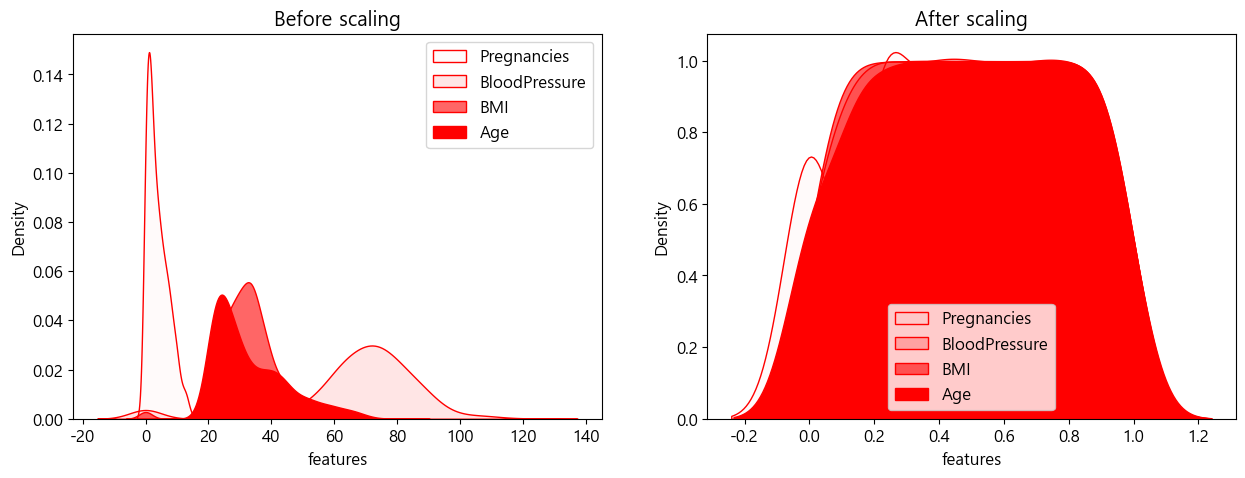

In [170]:
# scaling 전후 데이터 분포 비교 시각화
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col],alpha=a,legend=True,ax=ax[0], fill=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(qtu_X.columns, [0.02, 0.2, 0.6, 1]):
    sns.kdeplot(qtu_X[col], alpha=a, legend=True, ax=ax[1], fill=True, color='r')
ax[1].legend(qtu_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')

plt.show()

In [173]:
print("[Before] feature 별 데이터 분포 확인:")
print(X.describe().loc[['mean', 'std', 'max', 'min'], :], "\n")

# sklearn의 QuantileTransformer로 feature scaling
from sklearn.preprocessing import QuantileTransformer
qtn = QuantileTransformer(output_distribution = 'normal', n_quantiles=len(X))
qtn_X = qtn.fit_transform(X)
qtn_X = DataFrame(qtn_X, columns = X.columns)
print("[After] feature 별 데이터 분포 확인:")
print(qtn_X.describe().loc[['mean', 'std', 'max', 'min'], :])

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000 

[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean    -0.518602      -0.137647 -0.034803 -0.270105
std      2.066619       1.426041  1.150110  1.696606
max      5.199338       5.199338  5.199338  5.199338
min     -5.199338      -5.199338 -5.199338 -5.199338


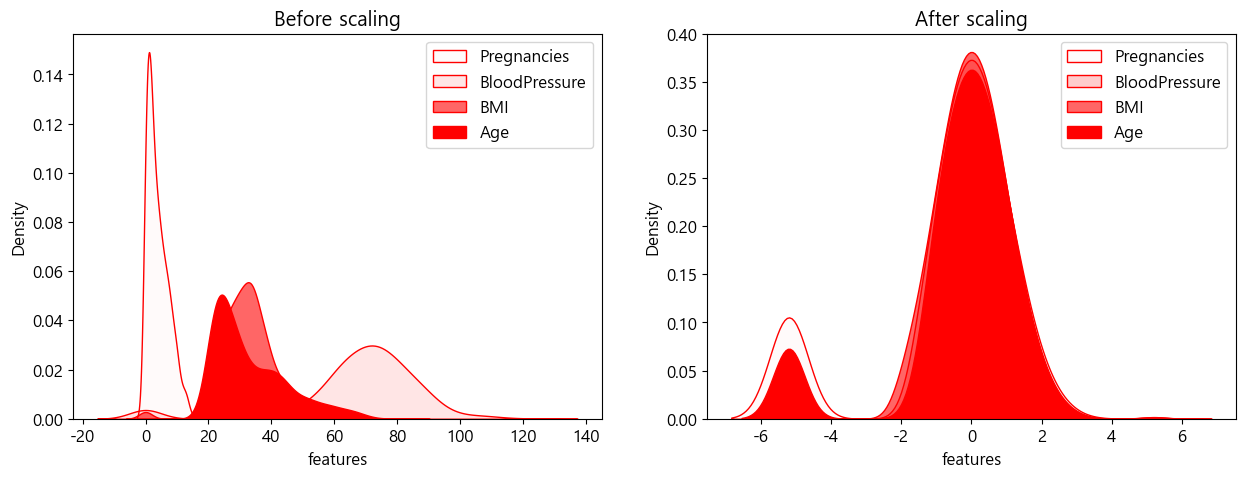

In [175]:
# scaling 전후 데이터 분포 비교 시각화
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
    sns.kdeplot(X[col],alpha=a,legend=True,ax=ax[0], fill=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(qtn_X.columns, [0.02, 0.2, 0.6, 1]):
    sns.kdeplot(qtn_X[col], alpha=a, legend=True, ax=ax[1], fill=True, color='r')
ax[1].legend(qtn_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')
plt.show()

#### Feature scaling한 데이터로 로지스틱회귀 분석 및 결과 비교

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

data = [X, ss_X, mm_X, rs_X, qtu_X, qtn_X]
y = diabetes['Outcome']
data_title=['no scaling', 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'QuantileUniform', 'QuantileNormal']
scores = DataFrame(index=['Train acc', 'Test acc', 'Train F1', 'Test F1'], columns=data_title)
coeffs = DataFrame(index=data_title, columns = X.columns)
for df, title in zip(data, data_title):
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=0)
    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    scores.loc['Train acc', title]= accuracy_score(y_train, pred_train)
    scores.loc['Test acc', title]= accuracy_score(y_test, pred_test)
    scores.loc['Train F1', title]= f1_score(y_train, pred_train)
    scores.loc['Test F1', title]= f1_score(y_test, pred_test)
    coeffs.loc[title, :] = lr.coef_
print(scores)

          no scaling StandardScaler MinMaxScaler RobustScaler QuantileUniform  \
Train acc     0.6875       0.689236     0.682292     0.689236        0.701389   
Test acc    0.692708       0.692708     0.682292     0.692708        0.692708   
Train F1    0.470588       0.471976     0.403909     0.471976         0.50289   
Test F1      0.40404        0.40404      0.26506      0.40404        0.427184   

          QuantileNormal  
Train acc       0.680556  
Test acc        0.697917  
Train F1        0.468208  
Test F1         0.395833  


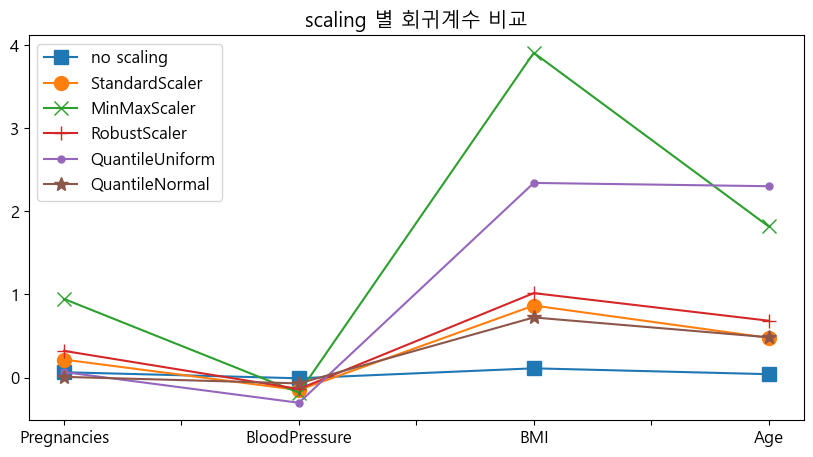

In [181]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("scaling 별 회귀계수 비교")
for i, marker in enumerate(['s', 'o', 'x', '+', '.', '*']):
    coeffs.T.iloc[:, i].plot(ax = ax, marker=marker, ms=10)
ax.legend()
plt.show()

#### 비선형변환: 로그변환

In [182]:
from pandas import read_csv
realestate = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_BHP.csv').dropna().reset_index(drop=True) # 결측치 삭제 후, 인덱스 리셋
X = realestate[['bath', 'balcony']] # 수치형 변수 두개만 사용
y = realestate[['price']]
print(realestate.head(3))

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2  Soiewre       1521   3.0      1.0   95.00  


In [183]:
import numpy as np
example_y = 39.07
print(f"원본 데이터: {example_y:.3f}")

# 상용로그
y_log = np.log10(example_y)
y_log_inv = 10**(y_log)
print(f"상용로그: {y_log:.3f} <---> {y_log_inv:.3f}")

# 자연로그
y_log2 = np.log(example_y) 
y_log2_inv = np.exp(y_log2) # 변환 전 값으로 되돌리기
print(f"자연로그: {y_log2:.3f} <--> {y_log2_inv:.3f}")

# 데이터에 1을 더한(plus) 후 자연로그
y_log3 = np.log1p(example_y) 
y_log3_inv = np.expm1(y_log3) # 변환 전 값으로 되돌리기
print(f"자연로그1p: {y_log3:.3f} <--> {y_log3_inv:.3f}")

# 데이터의 절대값에 자연로그 변환을 한 후, 데이터의 원래 부호 붙임
y_log4 = np.sign(example_y)*np.log(np.abs(example_y))
y_log4_inv = np.sign(y_log4)*np.exp(np.abs(y_log4))
print(f"절대값+자연로그+부호: {y_log4:.3f} <--> {y_log4_inv:.3f}")

원본 데이터: 39.070
상용로그: 1.592 <---> 39.070
자연로그: 3.665 <--> 39.070
자연로그1p: 3.691 <--> 39.070
절대값+자연로그+부호: 3.665 <--> 39.070


#### 비선형변환: 거듭제곱변환 (Box-cox, Yeo-Johnson)

In [184]:
from sklearn.preprocessing import PowerTransformer
PTB = PowerTransformer(method='box-cox')
PTY = PowerTransformer(method='yeo-johnson')
y_ptb = DataFrame(PTB.fit_transform(y), columns=y.columns)
y_pty = DataFrame(PTY.fit_transform(y), columns=y.columns)
y_ptb_inv = DataFrame(PTB.inverse_transform(y_ptb), columns=y.columns)
print("원본: ", y.head(1).values)
print("box-cox 변환: ", y_ptb.head(1).values)
print('box-cox 변환 되돌리기: ', y_ptb_inv.head(1).values)

원본:  [[39.07]]
box-cox 변환:  [[-1.06667464]]
box-cox 변환 되돌리기:  [[39.07]]


#### Target scaling한 데이터로 시각화, 선형 회귀 분석 및 결과 비교

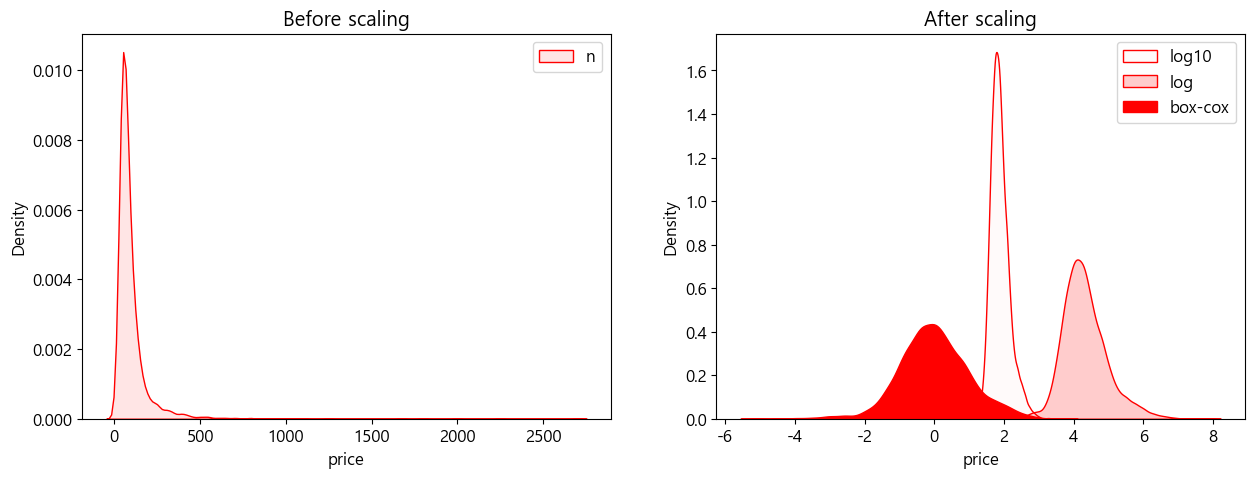

In [196]:
noscaling, log10, log, boxcox = y, np.log10(y), np.log(y), y_ptb
data = [noscaling, log10, log, boxcox]
data_title=['no scaling', 'log10', 'log', 'box-cox']
alphas = [0.1, 0.02, 0.2, 1]
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i, df, a in zip(range(len(data)), data, alphas):
    if i==0:
        sns.kdeplot(df['price'], ax=ax[0], alpha=a, fill=True, color='red')
        ax[0].legend(data_title[0])
        ax[0].set_title('Before scaling')
    else:
        sns.kdeplot(df['price'], ax=ax[1], alpha=a, fill=True, color='red')
        ax[1].legend(data_title[1:])
        ax[1].set_title('After scaling')
plt.show()

In [197]:
# Target scaling한 데이터로 선형회귀분석한 결과 비교
noscaling, log10, log, log1p, sblog, bc, yj = y, np.log10(y), np.log(y), np.log1p(y), np.sign(y)*np.log(np.abs(y)), y_ptb, y_pty
data = [noscaling, log10, log, log1p, sblog, bc, yj]
data_title=['no scaling', 'log10', 'log', 'log1p', 'sign+abs+log', 'box-cox', 'yeo-johnson']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
scores = DataFrame(index=['Train r2', 'Test r2'], columns=data_title)
for df, title in zip(data, data_title):
    X_train, X_test, y_train, y_test = train_test_split(X, df, random_state=0)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    scores.loc['Train r2', title]= lr.score(X_train, y_train)
    scores.loc['Test r2', title]= lr.score(X_test, y_test)
print(scores)

         no scaling     log10       log     log1p sign+abs+log   box-cox  \
Train r2   0.354048  0.548043  0.548043  0.548732     0.548043  0.521241   
Test r2    0.352965  0.547998  0.547998  0.548598     0.547998  0.524295   

         yeo-johnson  
Train r2    0.521324  
Test r2     0.524158  


#### 기타: 순위변환

In [235]:
print("[Before] feature 별 데이터 분포 확인:")
print(X.describe().loc[['mean', 'std', 'max', 'min'], :], '\n')

rank_X = X.rank(ascending=False)
print("[After] feature 별 데이터 분포 확인:")
print(rank_X.describe().loc[['mean', 'std', 'max', 'min'], :])

[Before] feature 별 데이터 분포 확인:
          bath   balcony
mean  2.458378  1.629936
std   0.881128  0.780127
max   9.000000  3.000000
min   1.000000  0.000000 

[After] feature 별 데이터 분포 확인:
             bath     balcony
mean  3748.500000  3748.50000
std   1926.118911  2010.62683
max   7282.500000  7295.50000
min      2.000000   503.00000


#### 기타: 구간분할 (Binning)

In [206]:
# pd.cut으로 구간분할
import pandas as pd
from pandas import cut, DataFrame
binned = pd.cut(X['bath'], 4) #bin수 지정
freq_df = DataFrame(binned.value_counts()).reset_index().rename(columns={'bath':'계급', 'count': '빈도'}).sort_values(by='계급', ascending = True)
print("bin수 지정:\n", freq_df, "\n")

bin_edges = [0, 2, 4, 6, float('inf')]
#right=False: 0이상~2미만, 2이상~4미만, 4이상~6미만, 6이상~
binned2 = cut(X['bath'], bin_edges, right=False) #bin의 범위 지정
freq_df2 = DataFrame(binned2.value_counts()).reset_index().rename(columns={'bath':'계급', 'count': '빈도'}).sort_values(by='계급', ascending = True)
print("bin범위 지정: \n", freq_df2, "\n")

bin수 지정:
              계급    빈도
0  (0.992, 3.0]  6774
1    (3.0, 5.0]   642
2    (5.0, 7.0]    77
3    (7.0, 9.0]     3 

bin범위 지정: 
            계급    빈도
2  [0.0, 2.0)   428
0  [2.0, 4.0)  6346
1  [4.0, 6.0)   642
3  [6.0, inf)    80 



In [221]:
# sklearn.preprocessing.KBinsDiscretizer로 구간 분할
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=3, strategy='quantile')
kb.fit(np.array(X['bath']).reshape(-1,1)) #reshape필요
print("bin edges: ", kb.bin_edges_[0]) #3개의 bin 구간이 생김

kbbin = kb.bin_edges_[0] 
bin_edges = [] #구간 리스트인 bin_edges를 만듬
for i in range(len(kbbin)):
    if len(kbbin)-1 != i:
        tup = (int(kbbin[i]), int(kbbin[i+1]))
        bin_edges.append(tup)
kbinned = kb.transform(np.array(X['bath']).reshape(-1,1))
result = DataFrame(kbinned.toarray(), columns=bin_edges)
print(result.head(3))

bin edges:  [1. 2. 3. 9.]
   (1, 2)  (2, 3)  (3, 9)
0     0.0     1.0     0.0
1     0.0     0.0     1.0
2     0.0     0.0     1.0


In [230]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=3, strategy='quantile')
kbinned = kb.fit_transform(np.array(X['bath']).reshape(-1,1)) #reshape필요
result = DataFrame(kbinned.toarray(), columns=bin_edges)
print(result.head(3))
print(kbinned.toarray())

   (1, 2)  (2, 3)  (3, 9)
0     0.0     1.0     0.0
1     0.0     0.0     1.0
2     0.0     0.0     1.0
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


#### **2-4-2. 범주형 변수 변환**

#### 원핫인코딩

In [236]:
from pandas import read_csv
realestate = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_BHP.csv').dropna().reset_index(drop=True) # 결측치 삭제 후, 인덱스 리셋
print(realestate.info(), "\n")

print("범주형 변수 기술 통계: ")
print(realestate.describe(include='object')) #Dtype이 object인 변수들의 기술 통계

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7496 entries, 0 to 7495
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     7496 non-null   object 
 1   availability  7496 non-null   object 
 2   location      7496 non-null   object 
 3   size          7496 non-null   object 
 4   society       7496 non-null   object 
 5   total_sqft    7496 non-null   object 
 6   bath          7496 non-null   float64
 7   balcony       7496 non-null   float64
 8   price         7496 non-null   float64
dtypes: float64(3), object(6)
memory usage: 527.2+ KB
None 

범주형 변수 기술 통계: 
                   area_type   availability    location   size  society  \
count                   7496           7496        7496   7496     7496   
unique                     4             74         634     15     2592   
top     Super built-up  Area  Ready To Move  Whitefield  2 BHK  GrrvaGr   
freq                    6017           5709  

#### 원핫인코딩

In [241]:
# 원본 데이터
print("범주형 변수의 수준 개수: ", realestate[['area_type']].nunique())
print(realestate[['area_type']].head(5), "\n")

# 원핫인코딩한 데이터
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
result = DataFrame(ohe.fit_transform(realestate[['area_type']]).toarray(), columns = ohe.categories_)
print("원핫인코딩 결과 feature의 개수: ", result.shape[1])
print(result.head(5))

범주형 변수의 수준 개수:  area_type    4
dtype: int64
              area_type
0  Super built-up  Area
1            Plot  Area
2  Super built-up  Area
3  Super built-up  Area
4            Plot  Area 

원핫인코딩 결과 feature의 개수:  4
  Built-up  Area Carpet  Area Plot  Area Super built-up  Area
0            0.0          0.0        0.0                  1.0
1            0.0          0.0        1.0                  0.0
2            0.0          0.0        0.0                  1.0
3            0.0          0.0        0.0                  1.0
4            0.0          0.0        1.0                  0.0


#### 더미코딩

In [242]:
# 원본 데이터
print("범주형 변수의 수준 개수: ", realestate[['area_type']].nunique())
print(realestate[['area_type']].head(5), '\n')

# 더미코딩한 데이터
from pandas import get_dummies
result2 = get_dummies(realestate[['area_type']], drop_first=True)
print("더미코딩 결과 feature의 개수: ", result2.shape[1])
print(result2.head(5))

범주형 변수의 수준 개수:  area_type    4
dtype: int64
              area_type
0  Super built-up  Area
1            Plot  Area
2  Super built-up  Area
3  Super built-up  Area
4            Plot  Area 

더미코딩 결과 feature의 개수:  3
   area_type_Carpet  Area  area_type_Plot  Area  \
0                   False                 False   
1                   False                  True   
2                   False                 False   
3                   False                 False   
4                   False                  True   

   area_type_Super built-up  Area  
0                            True  
1                           False  
2                            True  
3                            True  
4                           False  


#### 숫자로 표현된 범주형 특성 변환

In [243]:
# area_type의 데이터값이 숫자로 되어 있다고 가정 
realestate['area_type'] = realestate['area_type'].map({'Super built-up  Area':0, 'Plot  Area':1, 'Built-up  Area':2, 'Carpet  Area':3})
print(realestate.info())
print(realestate[['area_type']].describe(include='all'))
# area_type의 0, 1, 2, 3은 서열의 의미가 없는데 수치형 변수로 해석된다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7496 entries, 0 to 7495
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     7496 non-null   int64  
 1   availability  7496 non-null   object 
 2   location      7496 non-null   object 
 3   size          7496 non-null   object 
 4   society       7496 non-null   object 
 5   total_sqft    7496 non-null   object 
 6   bath          7496 non-null   float64
 7   balcony       7496 non-null   float64
 8   price         7496 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 527.2+ KB
None
         area_type
count  7496.000000
mean      0.365662
std       0.763294
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000


In [244]:
# 데이터 타입을 category로 변경: 수치형이지만 범주형 변수로 해석된다.
realestate['area_type'] = realestate['area_type'].astype('category')
print(" 기술 통계: \n", realestate[['area_type']].describe(include='all'))

 기술 통계: 
         area_type
count        7496
unique          4
top             0
freq         6017


#### 레이블인코딩

In [245]:
# 변수 'size'의 수준들을 확인: B(Bedroom), H(Hall), K(Kitchen), R(Room)을 의미
print(sorted(realestate['size'].unique()), "\n")
print(realestate[['size']].head(3))# 원본 데이터 확인

['1 BHK', '1 RK', '11 BHK', '2 BHK', '2 Bedroom', '3 BHK', '3 Bedroom', '4 BHK', '4 Bedroom', '5 BHK', '5 Bedroom', '6 BHK', '6 Bedroom', '7 BHK', '9 BHK'] 

        size
0      2 BHK
1  4 Bedroom
2      3 BHK


In [252]:
# Pandas의 Series에 .replace() 혹은 .map()을 사용
case1 = realestate['size'].replace({'1 RK':0, '1 BHK':1, '2 Bedroom':2, '2 BHK':3, '3 Bedroom':4, '3 BHK':5, '4 Bedroom':6, '4 BHK':7,  '5 Bedroom':8, '5 BHK':9, '6 Bedroom':10, '6 BHK':11,  '7 BHK':12, '9 BHK':13, '11 BHK':14})
print(case1.values[:5])

[3 6 5 3 6]


C:\Users\sunwa\AppData\Local\Temp\ipykernel_6684\3838916416.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  case1 = realestate['size'].replace({'1 RK':0, '1 BHK':1, '2 Bedroom':2, '2 BHK':3, '3 Bedroom':4, '3 BHK':5, '4 Bedroom':6, '4 BHK':7,  '5 Bedroom':8, '5 BHK':9, '6 Bedroom':10, '6 BHK':11,  '7 BHK':12, '9 BHK':13, '11 BHK':14})


In [253]:
# sklearn의 LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
case2 = le.fit_transform(realestate['size'])
print(case2[:5])
print(le.classes_) #label에 대응하는 수준을 확인 (위에 직접 지정한 것과 다름)

[3 8 5 3 8]
['1 BHK' '1 RK' '11 BHK' '2 BHK' '2 Bedroom' '3 BHK' '3 Bedroom' '4 BHK'
 '4 Bedroom' '5 BHK' '5 Bedroom' '6 BHK' '6 Bedroom' '7 BHK' '9 BHK']


#### 특징해싱

In [265]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher (n_features=5, input_type='string')
raw_X = realestate['size'].apply(lambda x: [x]).tolist() 
hash_df = fh.transform (raw_X)
hash_df = pd.DataFrame(hash_df.todense(), columns = [f"feature_{i}" for i in range(5)])
print(hash_df.value_counts(), "\n")
print(realestate['size'].value_counts())

feature_0  feature_1  feature_2  feature_3  feature_4
 1.0        0.0        0.0        0.0        0.0         3626
 0.0        0.0        0.0       -1.0        0.0         3013
           -1.0        0.0        0.0        0.0          353
-1.0        0.0        0.0        0.0        0.0          347
 0.0        0.0        0.0        1.0        0.0          121
                      -1.0        0.0        0.0           16
                       0.0        0.0       -1.0           16
            1.0        0.0        0.0        0.0            3
            0.0        0.0        0.0        1.0            1
Name: count, dtype: int64 

size
2 BHK        3411
3 BHK        3012
1 BHK         353
4 BHK         347
4 Bedroom     193
3 Bedroom     120
5 Bedroom      16
2 Bedroom      16
1 RK           10
5 BHK           9
6 BHK           3
6 Bedroom       3
11 BHK          1
9 BHK           1
7 BHK           1
Name: count, dtype: int64


#### 빈도인코딩

In [283]:
# 반복문으로 value_counts, map을 사용하여 빈도 인코딩
fe = realestate[['availability', 'society', 'total_sqft']]
for col in ['availability', 'society', 'total_sqft']:
    fe = fe.apply(lambda col: col.map(col.value_counts()))

    #텍스트북 버전은 작동하나 개선 필요 warning 표기
    # freq = fe[col].value_counts()
    # fe[col] = fe[col].map(freq)

print(fe.head(3))

   availability  society  total_sqft
0           157      285         198
1          5709      165         230
2          5709       88         468


In [281]:
realestate[['availability', 'society', 'total_sqft']].head(3)

,availability,society,total_sqft
0,19-Dec,Coomee,1056
1,Ready To Move,Theanmp,2600
2,Ready To Move,Soiewre,1521


In [282]:
# availability 변수의 수준별 빈도 확인: 19-Dec(157건), Ready To Move(5709건)
realestate['availability'].value_counts()

availability
Ready To Move    5709
18-Dec            180
18-May            171
19-Dec            157
18-Apr            148
                 ... 
20-Feb              1
15-Jun              1
20-Mar              1
16-Mar              1
14-Jul              1
Name: count, Length: 74, dtype: int64

#### 연습문제 #1

In [1]:
from pandas import read_csv
df = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice1_bank.csv')
print(df.head(3))

   age         job  marital  education default  balance housing loan  \
0   30  unemployed  married    primary      no     1787      no   no   
1   33    services  married  secondary      no     4789     yes  yes   
2   35  management   single   tertiary      no     1350     yes   no   

    contact month   y  
0  cellular   oct  no  
1  cellular   may  no  
2  cellular   apr  no  


In [2]:
# 결측치 없는 것으로 판단
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
month        0
y            0
dtype: int64

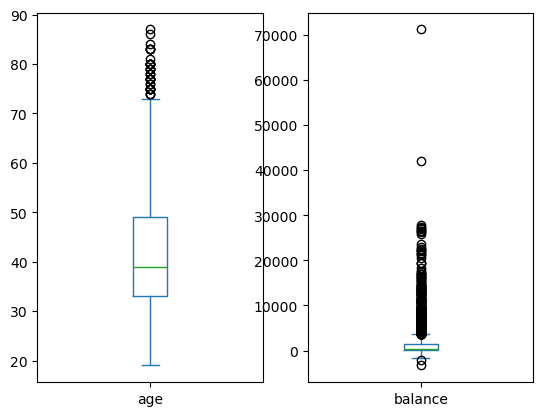

"\nfig, ax = plt.subplots (1,2)\nax[0].boxplot (df['age'])\nax[1].boxplot (df['balance'])\nplt.show()\n"

In [3]:
# 수치형 변수 age, balance에 관한 이상치 판단
import matplotlib.pyplot as plt
df.plot (kind='box', subplots=True)
plt.show()
'''
fig, ax = plt.subplots (1,2)
ax[0].boxplot (df['age'])
ax[1].boxplot (df['balance'])
plt.show()
'''

In [4]:
# age 이상치 분포는 합리적이라 판단하여 그대로 두고, balance 변수만 이상치 조치
IQR = df['balance'].quantile(0.75) - df['balance'].quantile(0.25)
top = df['balance'].quantile(0.75) + IQR * 1.5
down = df['balance'].quantile(0.25) - IQR * 1.5
outlier_index = df[((df['balance']>top) | (df['balance']<down))].index

len(outlier_index)

506

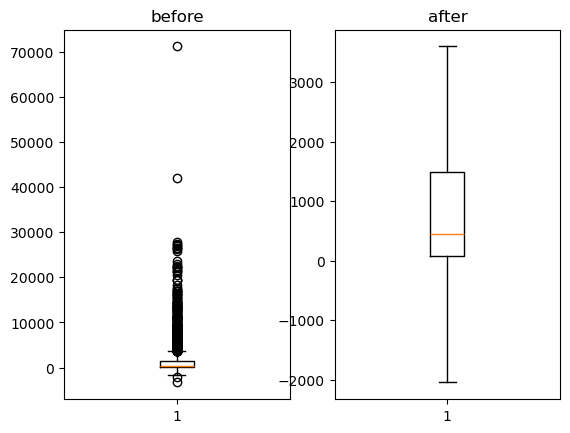

In [5]:
# 이상치가 506개로 상당한 수준이므로 절단보다는 상한/하한 값으로 조정
df1 = df.copy()
df1['balance'] = df['balance'].clip(down,top)

fig, ax = plt.subplots (1,2)
ax[0].boxplot (df[['balance']])
ax[0].set_title('before')
ax[1].boxplot (df1[['balance']])
ax[1].set_title('after')
plt.show()

#### 연습문제 #2

In [359]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,2
top,management,married,secondary,no,yes,no,cellular,may,no
freq,969,2797,2306,4445,2559,3830,2896,1398,4000


In [360]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,oct,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,may,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,apr,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,jun,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,may,no


In [12]:
# 범주형 변수 전처리 방법에는 원핫코딩, 더미코딩, 레이블 인코딩, 특성 해싱, 빈도 인코딩 등이 존재 
# 그 중에서도 더미코딩은 범주형 변수의 수준이 n개일 때 가변수 n-1개를 생성함으로써 다중공선성을 방지하는 변수변환 방법이다. 레이블 인코딩은 문자열인 수준들을 숫자로 맵핑하는 변수변환 방법이다. 
# 이진변수는 0과 1만 표기하면 되므로 레이블 인코딩, 서열척도도 레이블 인코딩이 적합

df2 = df1.copy()
# 이진변수 레이블 인코딩
for col in ['default', 'housing', 'loan', 'y']:
    df2[col] = df2[col].map({'yes':1, 'no':0})

# 서열척도 변수 레이블 인코딩
df2['education'] = df2['education'].map({'primary':1, 'secondary':2, 'tertiary':3, 'unknown':0})

# 명목척도는 더미코딩
import pandas as pd
df2 = pd.get_dummies(df2, columns=['marital', 'job', 'contact', 'month']) 
print(df2.head())

   age  education  default  balance  housing  loan  y  marital_divorced  \
0   30          1        0   1787.0        0     0  0             False   
1   33          2        0   3596.5        1     1  0             False   
2   35          3        0   1350.0        1     0  0             False   
3   30          3        0   1476.0        1     1  0             False   
4   59          2        0      0.0        1     0  0             False   

   marital_married  marital_single  ...  month_dec  month_feb  month_jan  \
0             True           False  ...      False      False      False   
1             True           False  ...      False      False      False   
2            False            True  ...      False      False      False   
3             True           False  ...      False      False      False   
4             True           False  ...      False      False      False   

   month_jul  month_jun  month_mar  month_may  month_nov  month_oct  month_sep  
0      Fals

#### 연습문제 #3

In [18]:
# 수치형 변수 전처리 방법은 표준화, 최대최소 스케일링, 로그변환, 순위변환, 구간분할 등이 존재
# age와 balance는 수치형 변수인데 이 변수들의 단위는 차이가 크다. 모델을 학습할 때 값의 범위가 큰 특성이거나, 특성 간에 척도가 크게 다를 경우 
# 회귀계수가 왜곡되거나 학습이 제대로 이루어지지 않을 수 있기 때문에 변수 변환이 필요하다.
# 일반적으로 feature scaling에 사용하는 방법으로 표준화(standardization)와 최소최대 스케일링(Min-max scaling)이 있다. 
  # 표준화: 각 특성들은 0에 가까운 평균을 가지게 되며, 대등하게 비교할 수 있는 스케일을 갖게 된다. 반면, 여전히 이상치의 영향을 받으며, 최솟값과 최댓값의 크기를 제한하지 않기 때문에 특성의 범위가 여전히 클 수 있다는 단점이 있다.
  # 최소최대 스케일링: 모든 특성이 정확하게 0과 1 사이에 위치하도록 데이터를 변경하기 때문에 이미지 데이터의 픽셀값과 같이 처음부터 범위가 정해진 변수는 최소최대 스케일링을 이용하면 자연스럽다. 반면, 변환후 평균이 정확히 0이되지 않고 이상치의 영향을 받기 쉽다는 단점이 있다.

from sklearn.preprocessing import StandardScaler
df3 = df2.copy()
ss = StandardScaler()
df3[['age', 'balance']] = ss.fit_transform (df3[['age', 'balance']])

                age    education      default       balance      housing  \
count  4.521000e+03  4521.000000  4521.000000  4.521000e+03  4521.000000   
mean  -1.178737e-16     2.065915     0.016810  7.701083e-17     0.566025   
std    1.000111e+00     0.780906     0.128575  1.000111e+00     0.495676   
min   -2.096455e+00     0.000000     0.000000 -2.435854e+00     0.000000   
25%   -7.725828e-01     2.000000     0.000000 -7.293014e-01     0.000000   
50%   -2.052091e-01     2.000000     0.000000 -4.269355e-01     1.000000   
75%    7.404137e-01     3.000000     0.000000  4.084006e-01     1.000000   
max    4.333780e+00     3.000000     1.000000  2.114953e+00     1.000000   

              loan            y  
count  4521.000000  4521.000000  
mean      0.152842     0.115240  
std       0.359875     0.319347  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000  


#### 연습문제 #4

In [28]:
# 데이터 불균형이란 타겟변수의 클래스 수가 불균형한 데이터 상황을 뜻하는데, 
# 본 데이터의 타겟변수인 y의 클래스 비율을 살펴보면 아래와 같이 88% : 12%로 차이가 많이 나기에 해당 데이터는 불균형이라고 할 수 있다.
y_count = pd.DataFrame(df3['y'].value_counts(), columns= ['count'])
y_count['%'] = df3['y'].value_counts(normalize=True) 
y_count

,count,%
y,,
0,4000,0.88476
1,521,0.11524


#### 연습문제 #5

In [40]:
# 불균형 데이터를 처리하기 위한 방법으로는 오버샘플링과 언더샘플링이 있는데, 본 데이터와 같이 데이터 크기가 비교적 작은 경우에는 오버샘플링을 진행한다. 오버샘플링 방법들에는 랜덤오버샘플링, SMOTE, Borderline SMOTE, K-means SMOTE, SVM SMOTE, ADASYN이 있다.
# 랜덤오버샘플링은 기존에 존재하는 소수의 클래스를 단순 복제하여 클래스가 불균형 하지 않도록 비율을 맞춰주는 방법이다. 분포의 변화는 없으나 소수 클래스의 숫자가 늘어나기 때문에 더 많은 가중치를 받게 되어 유효하다고 본다. 예측변수가 질적변수이거나 결측치가 있어도 전처리가 필요없다. 반면, 과적합의 위험이 있다.
# SVM SMOTE는 SVM 알고리즘으로 데이터를 학습함으로써 생성되는 support vector 데이터들 중에서 소수 클래스 데이터들을 경계 데이터로 삼아 SMOTE를 적용하는 방법이다. 이 때문에 support vector로서 유효한 소수 클래스 데이터들이 오버샘플링된다는 장점을 가진다. 반면, 데이터를 학습해서 생성해야 하기 때문에 랜덤오버샘플링보다는 시간이 좀 더 걸릴 수 있고, 예측변수들의 값이 모두 수치형이어야 하고, 결측값이 없어야한다는 단점이 있다.

df5 = df3.copy()
from imblearn.over_sampling import SVMSMOTE 
os = SVMSMOTE(random_state=0, k_neighbors=3)
x = df5.drop('y', axis=1)
y = df5[['y']]
x_sampled, y_sampled = os.fit_resample(x,y)

df5 = pd.concat ([x_sampled, y_sampled], axis=1)
df5['y'].value_counts()

y
0    4000
1    4000
Name: count, dtype: int64